In [1]:
import sys
sys.path.append("../../")
from datahandling import BcomMEG
import matplotlib.pyplot as plt
import numpy as np
import pywt
import mne
dir = '/Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT'
epo_files = []
subjects = ['BCOM_18_2']
avoid_reading = True

data = BcomMEG(dir=dir, subjects=subjects, avoid_reading=avoid_reading)

Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_18_2_re_144-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_18_2_i_116-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_18_2_a_112-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
16 matching events found
No baseline correct

In [4]:
data.data

{'BCOM_18_2': {'re_144': <EpochsFIF | 8 events (all good), -0.3 – 0.5 s (baseline off), ~4.0 MB, data loaded,
   '144': 8>,
  'i_116': <EpochsFIF | 12 events (all good), -0.3 – 0.5 s (baseline off), ~5.8 MB, data loaded,
   '116': 12>,
  'a_112': <EpochsFIF | 16 events (all good), -0.3 – 0.5 s (baseline off), ~7.6 MB, data loaded,
   '112': 16>,
  'ri_146': <EpochsFIF | 13 events (all good), -0.3 – 0.5 s (baseline off), ~6.3 MB, data loaded,
   '146': 13>,
  'sa_152': <EpochsFIF | 13 events (all good), -0.3 – 0.5 s (baseline off), ~6.3 MB, data loaded,
   '152': 13>,
  'ma_132': <EpochsFIF | 18 events (all good), -0.3 – 0.5 s (baseline off), ~8.5 MB, data loaded,
   '132': 18>,
  'ra_142': <EpochsFIF | 14 events (all good), -0.3 – 0.5 s (baseline off), ~6.7 MB, data loaded,
   '142': 14>,
  'te_164': <EpochsFIF | 10 events (all good), -0.3 – 0.5 s (baseline off), ~4.9 MB, data loaded,
   '164': 10>,
  'si_156': <EpochsFIF | 6 events (all good), -0.3 – 0.5 s (baseline off), ~3.1 MB, dat

In [2]:
re_1_1 = data.data['BCOM_18_2']['re_144'][0][0]
re_to_smooth = re_1_1.get_data()

In [6]:
re_1_1.info['sfreq']

300.0

In [7]:
re_to_smooth.shape

(1, 247, 241)

### Discrete Wavelet Transform

In [13]:
#discrete wavelet transform 
def dwt_denoise(data, wavelet='db4', level=7):
    coefficients = pywt.wavedec(data, wavelet, level=level)
    coefficients[-1] = np.zeros_like(coefficients[-1]) #d1 #get rid of these two as in Dash et al 2020.
    coefficients[-2] = np.zeros_like(coefficients[-2]) #d2
    return pywt.waverec(coefficients, wavelet)[:len(data)]


In [14]:
denoized_epochs = np.zeros_like(re_to_smooth)
for epoch_idx in range(re_to_smooth.shape[0]):
    for channel_idx in range(re_to_smooth.shape[1]):
        signal = re_to_smooth[epoch_idx, channel_idx, :]
        denoized_epochs[epoch_idx, channel_idx, :] = dwt_denoise(signal, wavelet='db4', level=5)



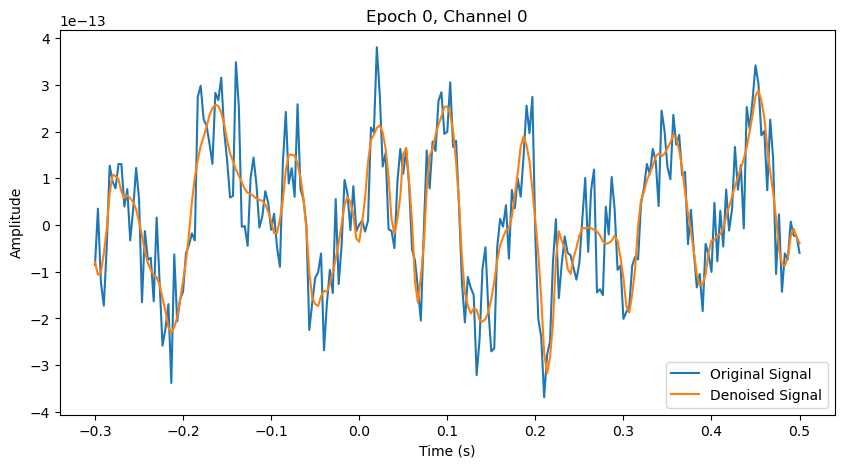

In [15]:
epoch_idx = 0  # Select an epoch
channel_idx = 0  # Select a channel

plt.figure(figsize=(10, 5))
plt.plot(re_1_1.times, re_to_smooth[epoch_idx, channel_idx, :], label="Original Signal")
plt.plot(re_1_1.times, denoized_epochs[epoch_idx, channel_idx, :], label="Denoised Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.title(f"Epoch {epoch_idx}, Channel {channel_idx}")
plt.show()

### Continuous Wavelet transform

In [3]:
def scalogram_dereconstruction(data, wavelet='db4', level=7):
    # First decompose
    coefficients = pywt.wavedec(data, wavelet, level=level)
    coefficients[-1] = np.zeros_like(coefficients[-1]) #d1 #get rid of these two as in Dash et al 2020.
    coefficients[-2] = np.zeros_like(coefficients[-2]) #d2
    # Reconstruct
    reconstructed_signal = pywt.waverec(coefficients, wavelet)[:len(data)]
    return reconstructed_signal

def scalogram_cwt(processed_data, wavelet, B, C, sampling_rate, log_samples):
    wavelet = f'{wavelet}{B}-{C}'
    sampling_period = 1/sampling_rate
    frequencies = np.logspace(np.log10(1), np.log10(sampling_rate/2), log_samples)
    scales = pywt.central_frequency(wavelet=wavelet)/ (frequencies * sampling_period)
    coefficients, _ = pywt.cwt(data=processed_data, scales=scales, wavelet=wavelet, sampling_period=sampling_period)
    return coefficients




In [4]:
processed_epochs = np.zeros_like(re_to_smooth)
for epoch_idx in range(re_to_smooth.shape[0]):
    for channel_idx in range(re_to_smooth.shape[1]):
        signal = re_to_smooth[epoch_idx, channel_idx, :]
        processed_epochs[epoch_idx, channel_idx, :] = scalogram_dereconstruction(signal, wavelet='db4', level=5)

In [18]:
wavelet = pywt.Wavelet('db4')
max_level = pywt.dwt_max_level(data_len=re_to_smooth.shape[-1], filter_len=wavelet.dec_len)
print(f"Maximum Decomposition Level: {max_level}")

Maximum Decomposition Level: 5


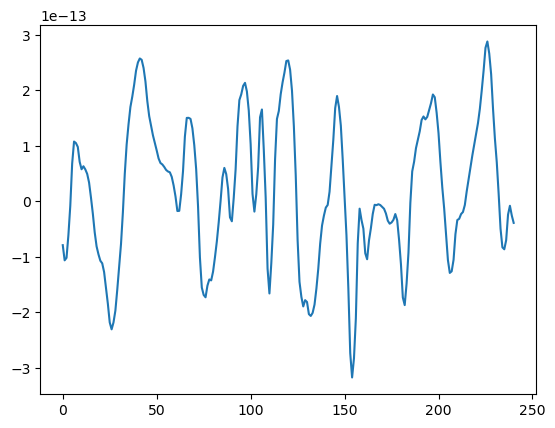

In [19]:
plt.plot(processed_epochs[0, 0, :])

### Scalogram stuff

Data is sorted, but need to get clear on scales? 

scales control the degree of stretching/compressing of the wavelet - the sliding of the wavelet over the data. 

small scales capture high frequencies, large scales correspond to low frequencies

For the CWT, sclaes are inversely proportional to frequency i.e. 

$$f = \frac{f_c}{\text{scale}\cdot \Delta t}$$

where $f_c$ is the ccenter frequency of the wavelet, and $\Delta t$ is the sampling period

pywt.scale2frequency(wavelet, scale) can convert scales to frequencies

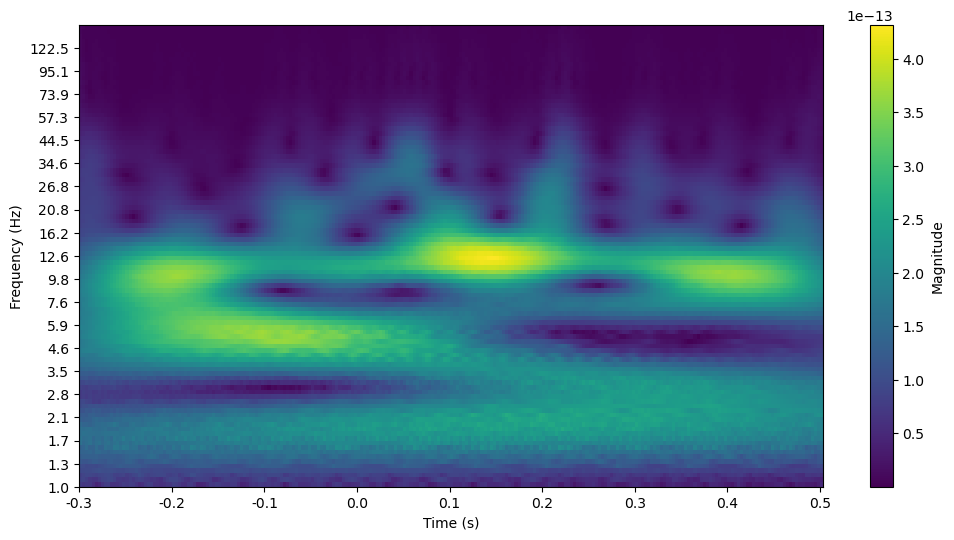

In [25]:
# wavelet and parameters
# wavelet = 'cmor' but it takes two parameters (kind of), B and C. 
# B is the bandwidth and C is the center frequency. 
# Higher B is a narrower frequency response, so better frequency res, poorer time res
# Lower B is a wider frequency response, so better time res, poorer frequency res

# Higher C is a higher frequency wavelet, so more oscillations. 
# Lower C is a lower frequency wavelet, so fewer oscillations.
B = 1.0
C = 1.0

wavelet = f'cmor{B}-{C}'

## in our case, the sampling period is 1/300 Hz
sampling_rate = 300
sampling_period = 1/sampling_rate

# so then the scales = f_c / f * dt where f_c is the central frequency of the wavelet and f is the frequency of interest
# and dt is the sampling period
# pywt.central_frequency gets the central frequency of the wavelet
frequencies = np.logspace(np.log10(1), np.log10(sampling_rate/2), 100)  # 100 frequencies
scales = pywt.central_frequency(wavelet=wavelet)/ (frequencies * sampling_period)  # 100 scales

# let's take the first epoch and first channel as the signal
signal = processed_epochs[0, 0, :]

coeffs, freqs = pywt.cwt(data=signal, scales=scales, wavelet=wavelet, sampling_period=sampling_period)

desired_times = np.array([-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
desired_indices = [np.where(re_1_1.times == time)[0][0] for time in desired_times]

plt.figure(figsize=(12, 6))
plt.pcolormesh(np.abs(coeffs), shading='auto', cmap='viridis')
plt.ylabel('Frequency (Hz)')
plt.yticks(np.arange(len(frequencies))[::5], 
          np.round(frequencies[::5], 1))  # Show every 5th frequency
plt.xlabel('Time (s)')

plt.xticks(ticks=desired_indices, labels=list(desired_times))
plt.colorbar(label='Magnitude')
plt.show()

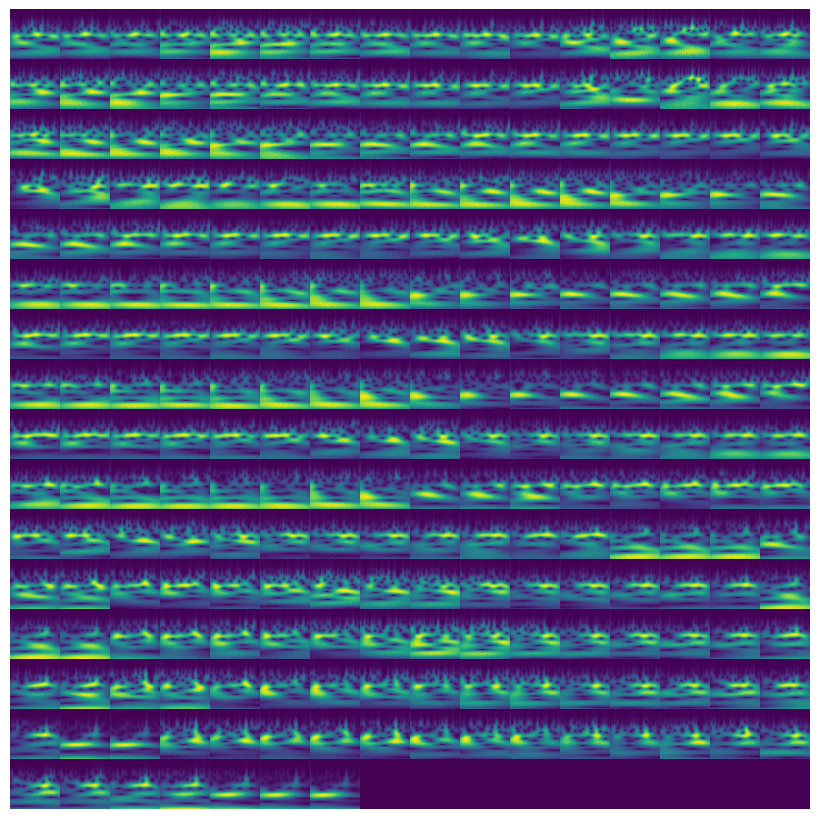

In [ ]:
#TODO: functionalize if I need to, it's kind of a pain
# lets see the entire brain for the first epoch
# re_to_smooth.shape (1, 247, 241)
fig, axes = plt.subplots(16, 16, figsize=(8, 8))
for idx in range(re_to_smooth.shape[1]):
        r, c = divmod(idx, 16)
        signal = re_to_smooth[0, idx, :]
        processed_epochs[0, idx, :] = scalogram_dereconstruction(signal, wavelet='db4', level=5)
        coefficients = scalogram_cwt(processed_epochs[0, idx, :], B=1.0, C=1.0, wavelet='cmor', sampling_rate=300, log_samples=100)
        axes[r, c].pcolormesh(np.abs(coefficients), cmap='viridis')
        # axes[r, c].set_title(f"Ch {idx}")
        axes[r, c].set_xticks([])
        axes[r, c].set_yticks([])
for idx in range(re_to_smooth.shape[1], 16*16):
    r, c = divmod(idx, 16)
    axes[r, c].pcolormesh(np.zeros((50, 241)), cmap='viridis')
    axes[r, c].set_xticks([])
    axes[r, c].set_yticks([])
for ax in axes.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0)
fig.patch.set_visible(False)
plt.savefig('scalogram.png', dpi=224) #9.1 seconds, dpi and size are 8x torch size
plt.show()
    


In [31]:
coefficients.shape

(100, 241)

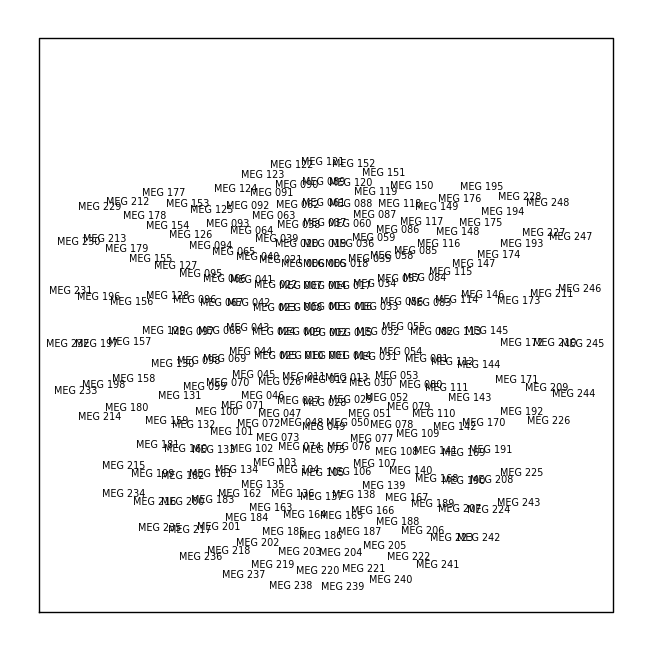

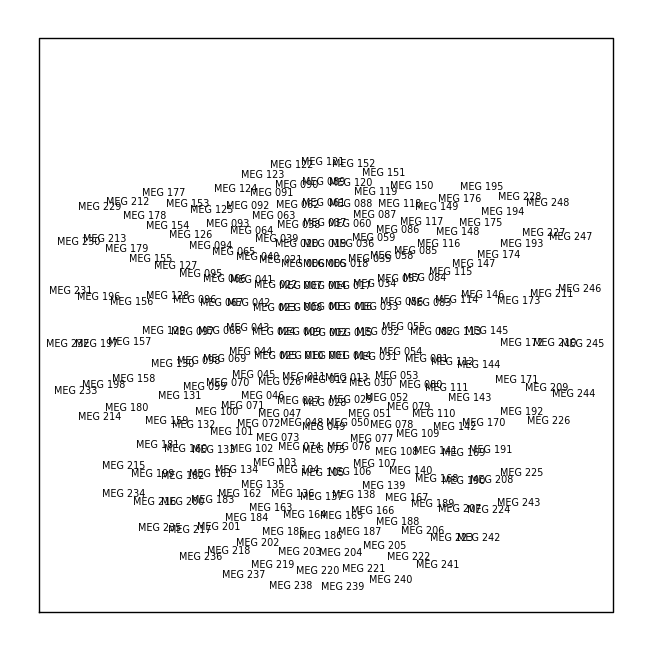

In [32]:
# get the layouts like in Deffosez et al. 
mne.find_layout(re_1_1.info, ch_type="meg").plot()

In [33]:
type(re_1_1)

mne.epochs.EpochsFIF

In [8]:
picks = mne.pick_types(re_1_1.info, meg=True)
sensor_coords = np.array([re_1_1.info['chs'][p]['loc'][:2] for p in picks])

In [9]:
len(sensor_coords) #247. 16x16 is 256. So we can add 9 dummies to make it 256. or take away 22 sensors to make it 15x15

coords_min = sensor_coords.min(axis=0)
coords_max = sensor_coords.max(axis=0)

normalized_coords = (sensor_coords - coords_min) / (coords_max - coords_min)

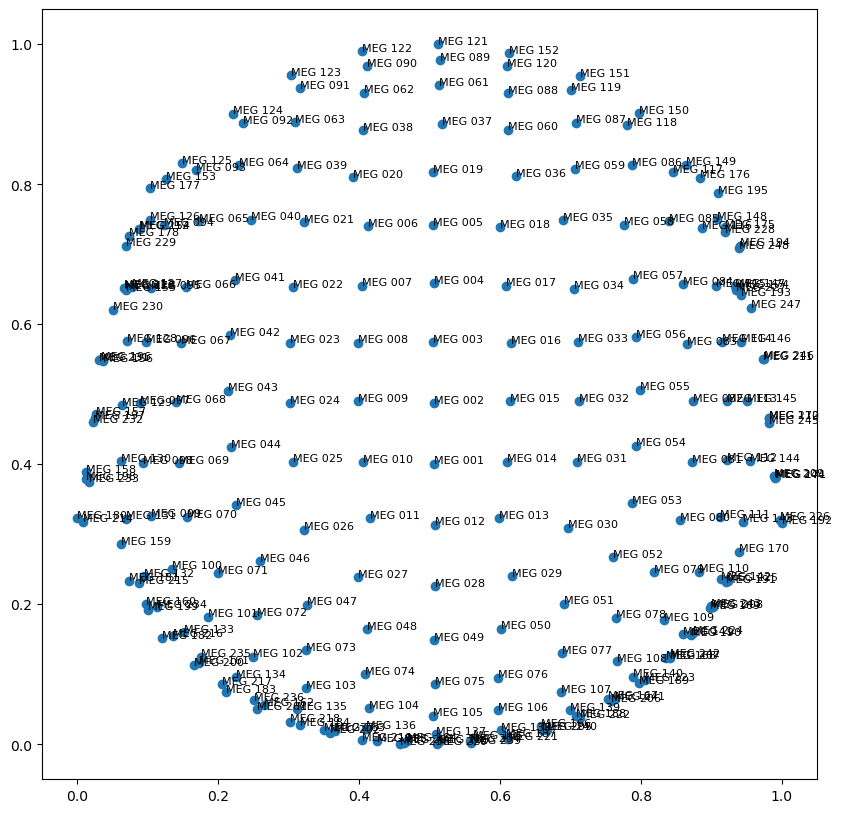

In [10]:
plt.figure(figsize=(10,10))
plt.plot(normalized_coords[:, 0], normalized_coords[:, 1], 'o')
for i, coord in enumerate(normalized_coords):
    plt.text(coord[0], coord[1], re_1_1.info['ch_names'][picks[i]], fontsize=8)

In [37]:
# cKDTree method doesnt work because the set of grid points is not the same as the set of sensor points.

# from scipy.spatial import cKDTree

# tree = cKDTree(grid_points)
# _, grid_indices = tree.query(normalized_coords, k=1)

# # Identify unoccupied grid points
# occupied_indices = set(grid_indices)
# all_indices = set(range(grid_size * grid_size))
# unoccupied_indices = list(all_indices - occupied_indices)

# final_coords = np.vstack([grid_points[grid_indices], grid_points[unoccupied_indices[:]]])

# plt.figure(figsize=(10, 10))
# plt.scatter(final_coords[:, 0], final_coords[:, 1], color='blue', label='Occupied')
# plt.scatter(grid_points[unoccupied_indices[:], 0], grid_points[unoccupied_indices[:], 1], color='red', label='Unoccupied')
# plt.legend()
# plt.gca().set_aspect('equal')
# plt.title('MEG Sensor Layout')
# plt.show()

In [38]:
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

max_grid_size = 100
avg_distances = []
for size in range(1, max_grid_size):
    grid_x, grid_y = np.meshgrid(np.linspace(0, 1, size), np.linspace(0, 1, size)) # make a 16x16 meshgrid
    grid_points = np.vstack([grid_x.ravel(), grid_y.ravel()]).T # flatten the meshgrid to get 256 points

    cost_matrix = cdist(normalized_coords, grid_points, metric='euclidean') # euclidean distance between cordinates and grid points
    row_indices, col_indices = linear_sum_assignment(cost_matrix) # Hungarian algorithm to minimize the total distance

    assigned_indices = set(col_indices) # indices of the grid points that are assigned to the sensor points
    all_indices = set(range(grid_points.shape[0])) # all indices of the grid points
    missing_indices = list(all_indices - assigned_indices) # 9 missing indices


    final_coords = np.vstack([grid_points[col_indices], grid_points[missing_indices]]) # putting everything together

    # Check that all grid points are unique
    assert len(set(col_indices)) == len(col_indices), "Duplicate grid assignments detected!"    
    
    # get the distances
    distances = np.linalg.norm(normalized_coords[:len(col_indices)] - grid_points[col_indices], axis=1)
    # average distance
    avg_distances.append(np.mean(distances))




Text(0.5, 1.0, 'Average Distance given Grid Size')

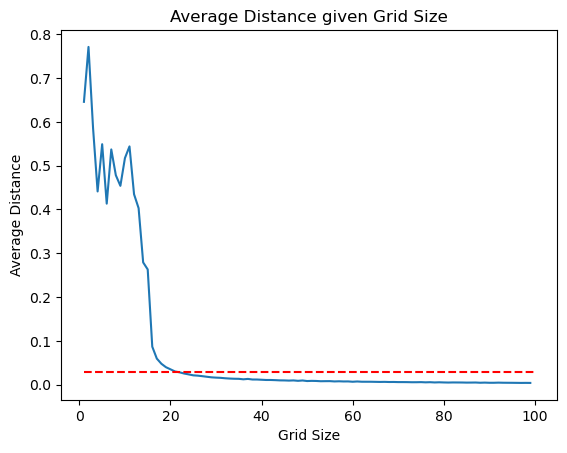

In [39]:
# How big should the grid be?
plt.plot(range(1, max_grid_size), avg_distances)
plt.xlabel('Grid Size')
plt.ylabel('Average Distance')
plt.hlines(0.03, 1, max_grid_size, color='red', linestyle='--') # want to be below 0.03
plt.title('Average Distance given Grid Size')

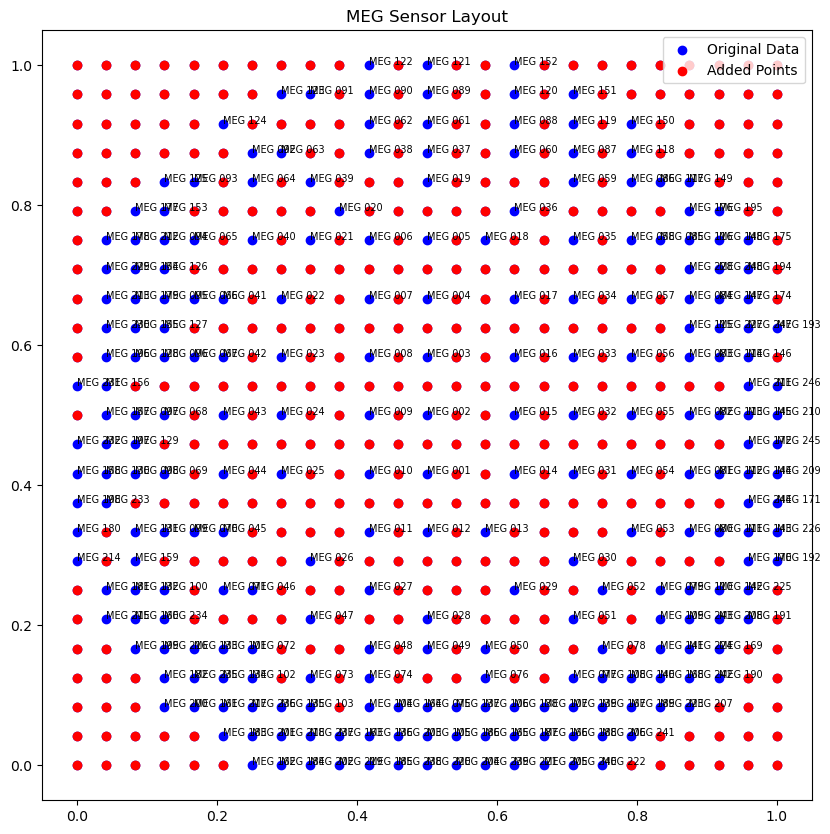

In [40]:
def meg_grid(mne_epoch_FIF, grid_size=25, meg=True):
    
    # working with meg sensors
    picks = mne.pick_types(mne_epoch_FIF.info, meg=meg)

    # get the sensor coordinates
    sensor_coords = np.array([mne_epoch_FIF.info['chs'][p]['loc'][:2] for p in picks])

    # normalize the coordinates
    coords_min = sensor_coords.min(axis=0)
    coords_max = sensor_coords.max(axis=0)

    normalized_coords = (sensor_coords - coords_min) / (coords_max - coords_min)

    # make a grid_sizexgrid_size meshgrid
    grid_x, grid_y = np.meshgrid(np.linspace(0, 1, grid_size), np.linspace(0, 1, grid_size)) 
    
    # flatten the meshgrid to get 256 points
    grid_points = np.vstack([grid_x.ravel(), grid_y.ravel()]).T 

    # euclidean distance between cordinates and grid points
    cost_matrix = cdist(normalized_coords, grid_points, metric='euclidean') 

    # Hungarian algorithm to minimize the total distance
    row_indices, col_indices = linear_sum_assignment(cost_matrix) 

    # indices of the grid points that are assigned to the sensor points
    assigned_indices = set(col_indices) 
    
    # all indices of the grid points
    all_indices = set(range(grid_points.shape[0])) 

    # include missing indices
    missing_indices = list(all_indices - assigned_indices) 

    # get the final coordinates
    final_coords = np.vstack([grid_points[col_indices], grid_points[missing_indices]]) # putting everything together

    # Check that all grid points are unique
    assert len(set(col_indices)) == len(col_indices), "Duplicate grid assignments detected!"

    return final_coords, grid_points, missing_indices
    
def plot_meg_grid(mne_epoch_FIF, grid_size=25, meg=True, labels=True, figsize=(10, 10)):

    #call meg_grid to get the info from the object
    final_coords, grid_points, missing_indices = meg_grid(mne_epoch_FIF, grid_size=grid_size, meg=meg)

    # set up the figure
    plt.figure(figsize=figsize)

    # plot the original data
    plt.scatter(final_coords[:, 0], final_coords[:, 1], color='blue', label='Original Data')

    # plot the interpolated data
    plt.scatter(grid_points[missing_indices, 0], grid_points[missing_indices, 1],
                color='red', label='Added Points')
    
    # if labels, label the points
    if labels:
        for i, coord in enumerate(final_coords[:len(sensor_coords)]):
            plt.text(coord[0], coord[1], mne_epoch_FIF.info['ch_names'][picks[i]], fontsize=7)
    
    # set the aspect ratio to be equal
    plt.gca().set_aspect('equal')
    plt.legend()
    plt.title('MEG Sensor Layout')
    plt.show()

#plot

plot_meg_grid(re_1_1, grid_size=25, labels=True, figsize=(10, 10))


In [41]:
def get_sorted_mappings(mne_epoch_FIF, grid_size=25, meg=True, dummies=True):
    
    # call meg_grid to get all of the neccesary co-ordinates
    final_coords, grid_points, missing_indices = meg_grid(mne_epoch_FIF, grid_size=grid_size, meg=meg)

    # get the picks from the object
    picks = mne.pick_types(mne_epoch_FIF.info, meg=meg)

    # create a dictionary with the mappings
    mappings = {mne_epoch_FIF.info['ch_names'][picks[i]]: final_coords[i] for i in range(len(picks))}
    dummy_sensors = []
    # create a list of dummies
    if dummies:
        dummy_sensors = [f"Dummy_{i}" for i in range(1, len(missing_indices) + 1)]

        for i, dummy in enumerate(dummy_sensors):
            mappings[dummy] = grid_points[missing_indices[i]]
        dummy_sensors = dummy_sensors
    # sort the dictionary by y first, then x i.e. top left to bottom right
    sorted_mappings = dict(sorted(mappings.items(), key=lambda x: (-x[1][1], x[1][0]))) 

    return sorted_mappings, dummy_sensors

sorted_mappings, dummies = get_sorted_mappings(re_1_1, grid_size=25, meg=True, dummies=True)
# mappings = {re_1_1.info['ch_names'][picks[i]]: final_coords[i] for i in range(len(picks))}
# dummies = [f"Dummy_{i}" for i in range(1, len(missing_indices) + 1)]

# for i, dummy in enumerate(dummies):
#     mappings[dummy] = grid_points[missing_indices[i]]

# # Cursed dictionary methods:

# sorted_mappings = dict(sorted(mappings.items(), key=lambda x: (-x[1][1], x[1][0]))) # sort by y first, then x

In [42]:
sorted_mappings #now I can generate a 22x22 grid of the scalograms

{'Dummy_357': array([0., 1.]),
 'Dummy_358': array([0.04166667, 1.        ]),
 'Dummy_359': array([0.08333333, 1.        ]),
 'Dummy_360': array([0.125, 1.   ]),
 'Dummy_361': array([0.16666667, 1.        ]),
 'Dummy_362': array([0.20833333, 1.        ]),
 'Dummy_363': array([0.25, 1.  ]),
 'Dummy_364': array([0.29166667, 1.        ]),
 'Dummy_365': array([0.33333333, 1.        ]),
 'Dummy_366': array([0.375, 1.   ]),
 'MEG 122': array([0.41666667, 1.        ]),
 'Dummy_367': array([0.45833333, 1.        ]),
 'MEG 121': array([0.5, 1. ]),
 'Dummy_368': array([0.54166667, 1.        ]),
 'Dummy_369': array([0.58333333, 1.        ]),
 'MEG 152': array([0.625, 1.   ]),
 'Dummy_370': array([0.66666667, 1.        ]),
 'Dummy_371': array([0.70833333, 1.        ]),
 'Dummy_372': array([0.75, 1.  ]),
 'Dummy_373': array([0.79166667, 1.        ]),
 'Dummy_374': array([0.83333333, 1.        ]),
 'Dummy_375': array([0.875, 1.   ]),
 'Dummy_376': array([0.91666667, 1.        ]),
 'Dummy_377': array

In [43]:
coefficients.shape

(100, 241)

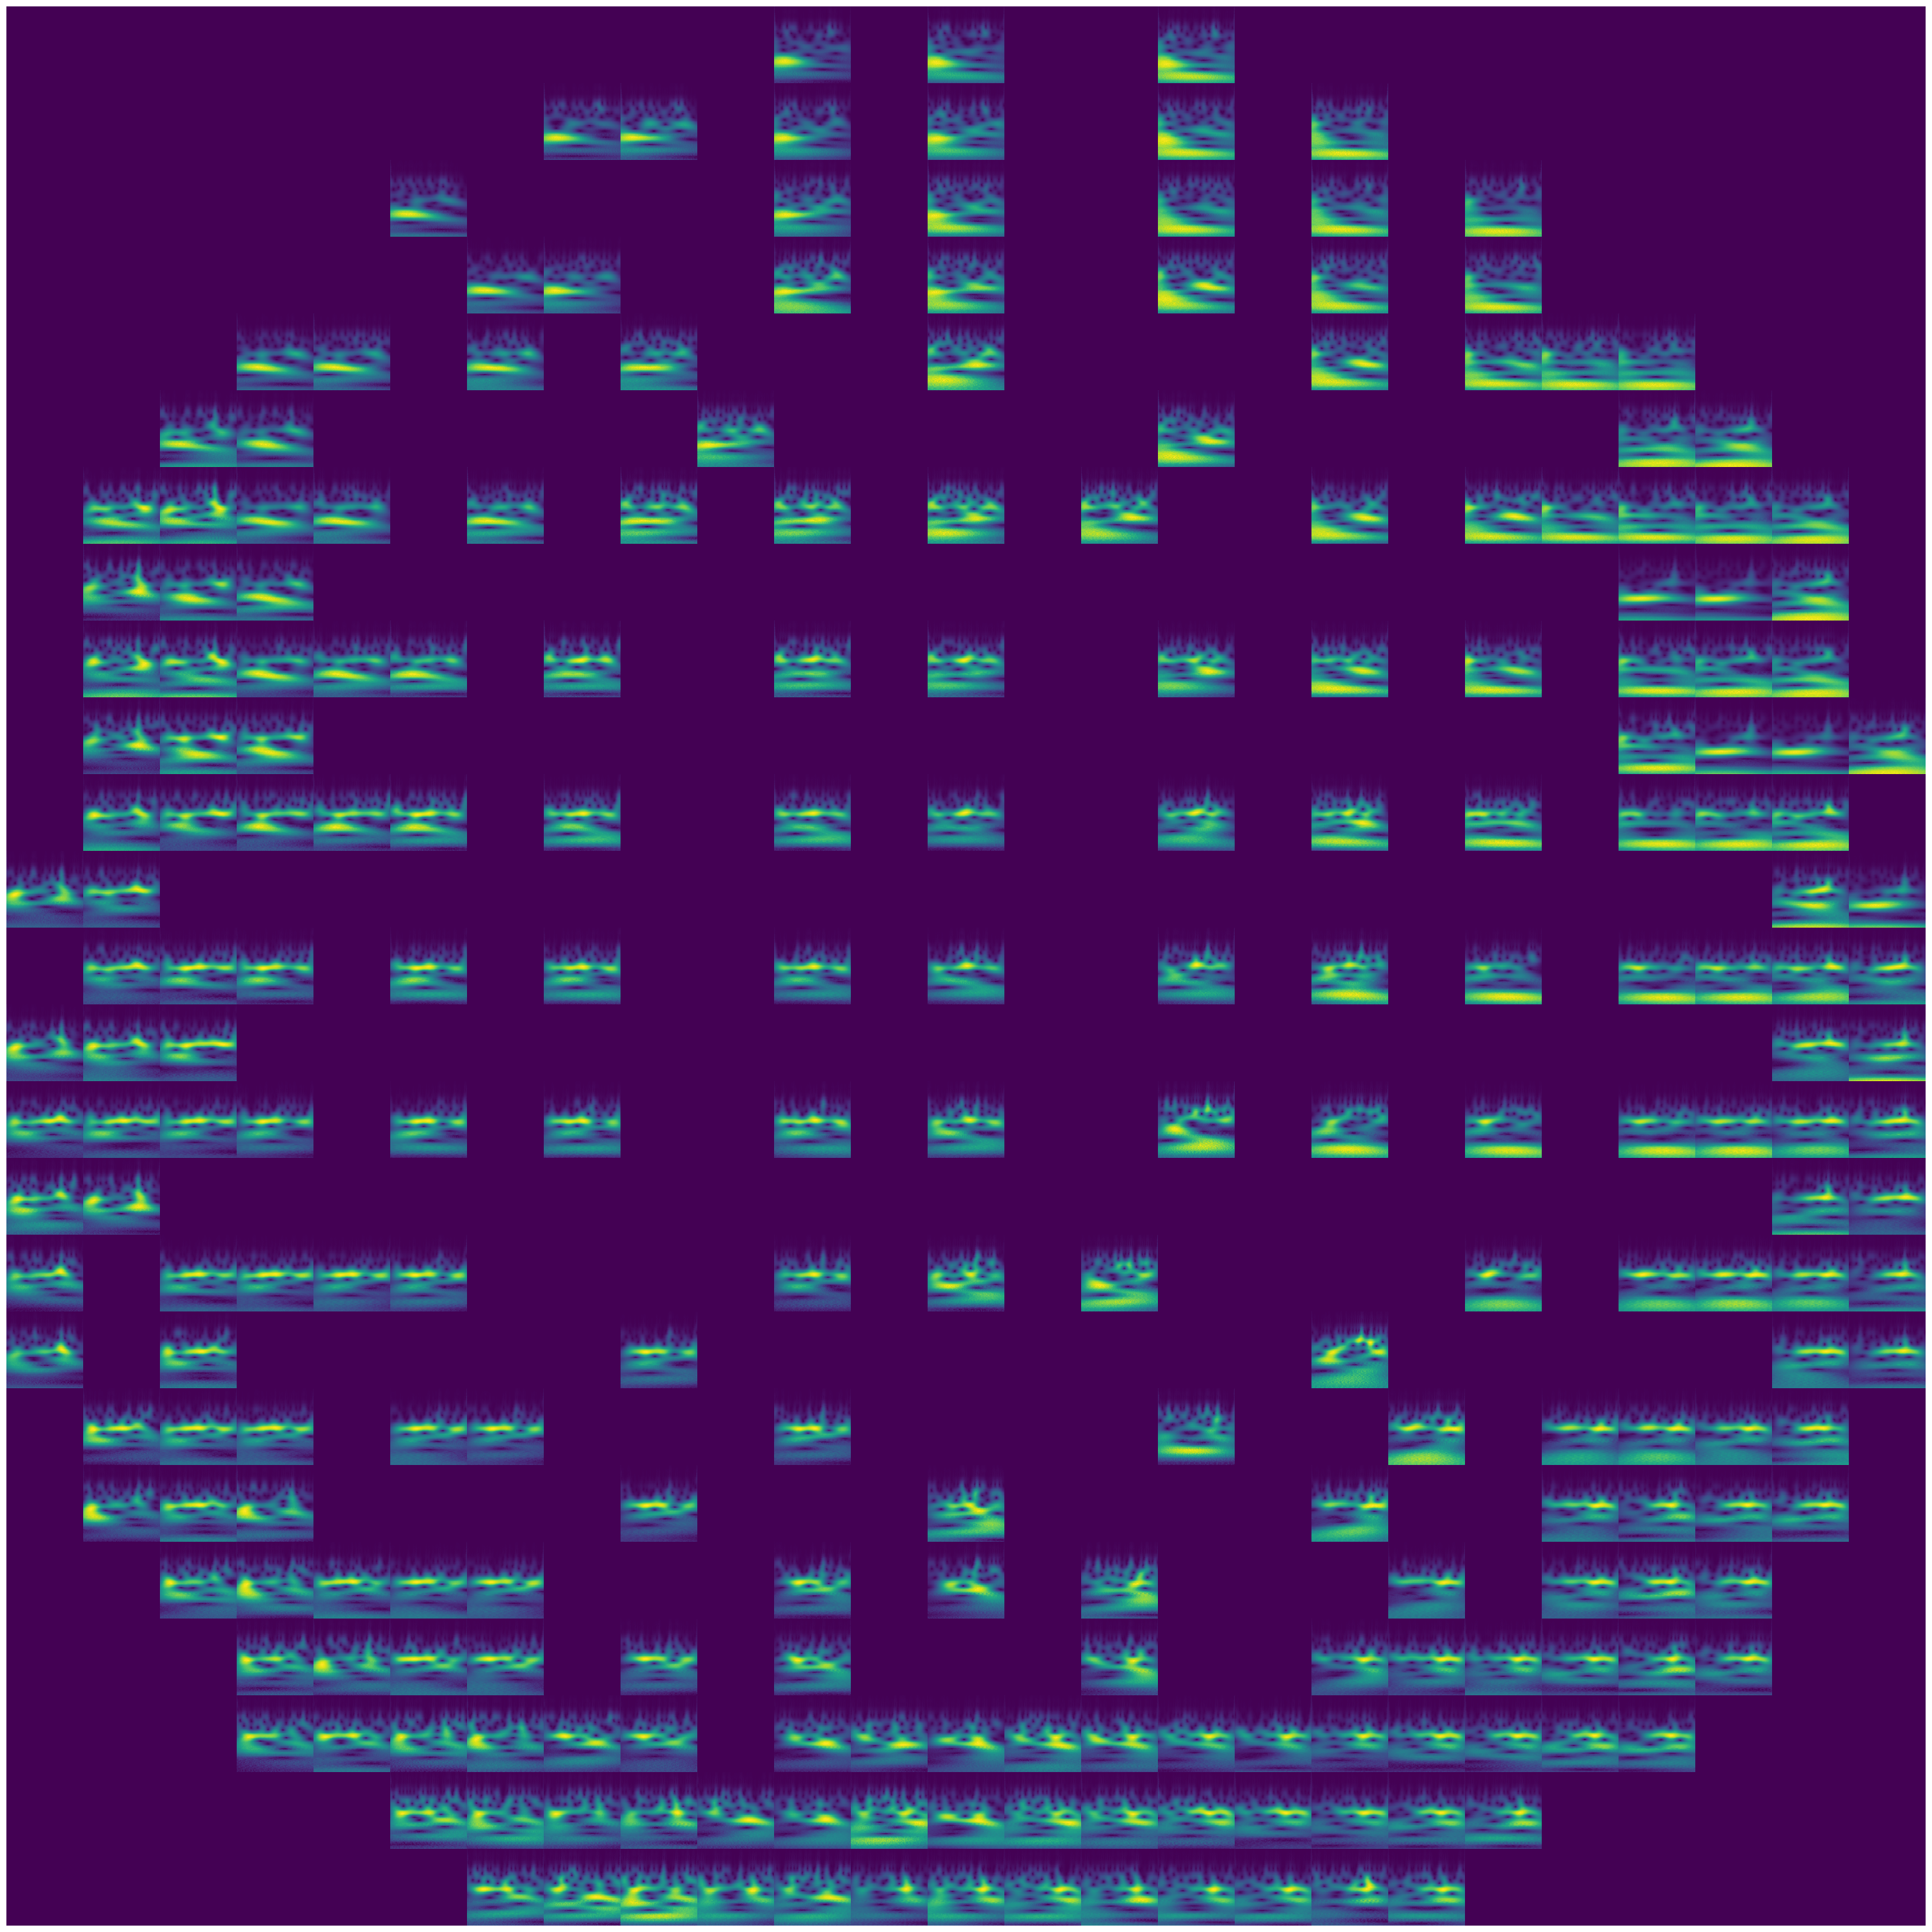

In [ ]:
#TODO: functionalize

# lets see the entire brain for the first epoch
# re_to_smooth.shape (1, 247, 241)
grid_size = 25
fig, axes = plt.subplots(grid_size, grid_size, figsize=(30, 30))
for sensor, value in sorted_mappings.items():
    if sensor not in dummies:
        r, c = divmod(list(sorted_mappings.keys()).index(sensor), grid_size)
        sensor_idx = re_1_1.info['ch_names'].index(sensor)
        signal = re_to_smooth[0, sensor_idx, :]
        processed_epochs[0, sensor_idx, :] = scalogram_dereconstruction(signal, wavelet='db4', level=5)
        coefficients = scalogram_cwt(processed_epochs[0, sensor_idx, :], B=1.0, C=1.0, wavelet='cmor', sampling_rate=300, log_samples=100)
        axes[r, c].pcolormesh(np.abs(coefficients), cmap='viridis')
        axes[r, c].set_xticks([])
        axes[r, c].set_yticks([])
        # axes[r, c].set_title(sensor)
    else:
        r, c = divmod(list(sorted_mappings.keys()).index(sensor), grid_size)
        axes[r, c].pcolormesh(np.zeros((50, 241)), cmap='viridis')
        axes[r, c].set_xticks([])
        axes[r, c].set_yticks([])
        # axes[r, c].set_title(sensor)

for ax in axes.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0)
fig.patch.set_visible(False)
plt.savefig('mapped_scalogram.png', dpi=315)
plt.show()